In [1]:
%matplotlib inline

from matplotlib_inline import backend_inline
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from datetime import datetime
from torch.utils import data
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

backend_inline.set_matplotlib_formats('svg')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
plt.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
# convert str to datatime
# 将字符串转换为时间
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
# 加载.mat格式的数据
def loadMat(matfile):
    data_mat = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data_mat[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_mat = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data_mat.append(d1)

    return data_mat

# get capacity data
# 得到电池容量的数据
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = './dataset/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data_mat = loadMat(path)
    Battery[name] = getBatteryCapacity(data_mat)

Load Dataset B0005.mat ...


C:\Users\Coyle\AppData\Local\Temp\ipykernel_28472\2811494779.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


In [3]:
len(Battery['B0018'][0]), len(Battery['B0018'][1])

(132, 132)

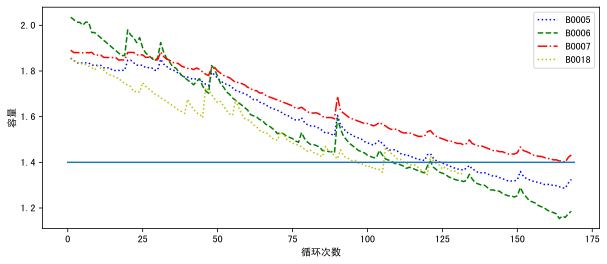

In [4]:
%matplotlib inline

color_list = ['b:', 'g--', 'r-.', 'y:']
# 1.创建画布
plt.figure(figsize=(10, 4), dpi=80)
plt.xlabel('循环次数')
plt.ylabel('容量')

# 2.绘制折线图
for name,color in zip(Battery_list, color_list):
    plt.plot(Battery[name][0], Battery[name][1], color)
    
plt.plot([i for i in range(170)], [1.4] * 170)

# 图例
plt.legend([name for name in Battery_list])

In [5]:
# 构建数据
# 采用 留一评估：一组数据为测试集，其他所有数据全部拿来训练
# train_x 的维度是 window_size ，总样本数为 421
# train_y 的维度是1，总样本数为421
# train_data 是模型预测时的真实数据，用来预测下一时刻的容量，长度为 window_size
# test_data 是 真实的容量数据，用来检验模型的各种参数

def build_seq(text, window_size):
    # text:list of capacity
    x, y = [], []
    for i in range(len(text) - window_size):
        sequence = text[i:i + window_size]
        # target = text[i + window_size] # y 只有一列
        target = text[i + 1:i + 1 + window_size] # y 有 window_size 列
        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)

def get_train_test_data(data_dict, name, window_size=16):
    data_sequence = data_dict[name][1]
    train_data, test_data = data_sequence[:window_size], data_sequence[window_size:]
    
    train_x, train_y = None, None
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_seq(text=v[1], window_size=window_size)
            if train_x is None:
                train_x = data_x
                train_y = data_y
            else:
                train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)

def load_capacity_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [6]:
# 平均绝对误差、均方根误差
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse

# 相对误差
# B0005 第125次循环后达到阈值1.4
# B0006 第109次循环后达到阈值1.4
# B0007 数据集中无任何值小于1.4，所以无法达到阈值1.4
# B0018 第97次循环后达到阈值1.4
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), len(y_predict)
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i + 1
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold >= y_predict[i + 1]:
            pred_re = i + 1
            break
    return abs(true_re - pred_re) / true_re

# relative_error(Battery['B0006'][1], Battery['B0006'][1], 1.4)

In [92]:
# 测试 train_iter 的数据是否正确
def validate_train_iter(train_iter):
    for X, Y in train_iter:
        print(X.shape)
        print(Y.shape)
        print(X[1])
        print(Y[1])
        print('Y[:, -1]', Y[:, -1].reshape(-1, 1).shape)
        break

    print(torch.from_numpy(np.array(Battery['B0006'][1][1:18])))

train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[0], window_size=16)
train_x = torch.from_numpy(train_x.astype(np.float32))
train_y = torch.from_numpy(train_y.astype(np.float32))
train_iter = load_capacity_data((train_x, train_y), 30, is_train=False)
validate_train_iter(train_iter)

torch.Size([30, 16])
torch.Size([30, 16])
tensor([2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572,
        1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783])
tensor([2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572, 1.9456,
        1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783, 1.8676])
Y[:, -1] torch.Size([30, 1])
tensor([2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572,
        1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783, 1.8676],
       dtype=torch.float64)


In [9]:
# 暂时用不到
# 获取 vocab_size，该值用于nn.Embedding
# 取 vocab_size 为 所有的训练数据集和测试数据集的前 window_size 个数
def get_vocab_size(i, window_size):
    """i 表示当前的留一评估是取的第i个电池为测试数据集"""
    vocab_size = window_size
    for j in range(len(Battery_list)):
        if j != i:
            battery_name = Battery_list[j]
            vocab_size += len(Battery[battery_name][1])
    return vocab_size

In [18]:
# 多头注意力  备份版本
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，
        # num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # output的形状:(batch_size*num_heads，查询的个数，
        # num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，
    # num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [7]:
# 多头注意力
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    def forward(self, queries, keys, values):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = nn.functional.softmax(scores, dim=-1)
        return torch.bmm(self.dropout(self.attention_weights), values)

class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values):
        # queries，keys，values的形状: (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        # output的形状:(batch_size*num_heads，查询的个数，num_hiddens/num_heads)
        output = self.attention(queries, keys, values)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数, num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数, num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)


# 测试 多头注意力的 输出
num_hiddens, num_heads = 100, 5
window_size = 16
attention = MultiHeadAttention(window_size, window_size, window_size,
                               num_hiddens, num_heads, 0.5)
print(attention.eval())

batch_size, num_queries = 2, 4
num_kvpairs = 6
X = torch.ones((30, 1, window_size))
Y = torch.ones((30, 1, window_size))
attention(X, Y, Y).shape

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=16, out_features=100, bias=False)
  (W_k): Linear(in_features=16, out_features=100, bias=False)
  (W_v): Linear(in_features=16, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)


torch.Size([30, 1, 100])

In [8]:
# 层规范化
# 假设此时输入的数据维度是[3, 4]，则对3个长度为4的向量求均值方差，得到3个均值和3个方差
# 分别对这3行进行归一化（每一行的4个数字都是均值为0，方差为1） 
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [9]:
# 前馈网络层
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 8])

In [10]:
# 模型 暂时保存不用
class Net(nn.Module):
    def __init__(self, embed_size, window_size, n_class=1, max_len=1000):
        super(Net, self).__init__()
        
        # 嵌入层来自于nlp，但是不知道是否适用于容量时序数据
        # 嵌入层只使用整型数据，容量数据是浮点型数据，不适用嵌入层
        # self.embedding = nn.Embedding(vocab_size, embed_size) # 嵌入层
        
        # 用线性层扩展维度来代替 nn.Embedding
        self.embedding = nn.Linear(1, embed_size)
        
        # 位置嵌入是可学习的，因此创建一个足够长的位置嵌入参数，该方法来自于bert
        # bert模型大，训练数据集也够大，所以使用可学习的位置嵌入
        # 锂电池容量数据集不大，不一定适合可学习的位置嵌入
        self.pos_embedding = nn.Parameter(torch.randn(1, window_size, embed_size)) # torch.randn 满足标准正态分布
        

    def forward(self, x): # 输入x 的形状是 (batch_size, window_size)
        X = x.unsqueeze(2) # 输出 X shape: (batch_size, window_size, 1)
        X = self.embedding(X) # 输出 X shape: (batch_size, window_size, embed_size)
        X = X + self.pos_embedding.data # X shape: (batch_size, window_size, embed_size),这里使用的广播机制
        
        
        return X

In [10]:
# 注意力机制块
class AttentionBlock(nn.Module):
    """注意力机制块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads,
                 norm_shape, ffn_num_input, ffn_num_hiddens, dropout, use_bias=False, **kwargs):
        super(AttentionBlock, self).__init__(**kwargs)
        
        # 多头注意力层
        self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        
        # 层规范化
        self.addnorm1 = AddNorm(norm_shape, dropout)
        
        # 前馈网络层
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        
        # 层规范化
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, Y):
        # attention 的输出 shape: (batch_size, 1, window_size)
        # addnorm1 的输出 shape: (batch_size, 1, window_size)
        X = self.addnorm1(X, self.attention(X, Y, Y))
        
        # ffn 的输出 shape: (batch_size, 1, window_size)
        # addnorm2 的输出 shape: (batch_size, 1, window_size)
        X = self.addnorm2(X, self.ffn(X))
        
        return X

In [11]:
# 残差网络
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, strides=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        
        Y += X
        return F.relu(Y)

# blk = Residual(3,3)
# X = torch.rand(4, 3, 6, 6)
blk = Residual(1, 8)
X = torch.rand(30, 1, 4, 4)
Y = blk(X)
Y.shape

torch.Size([30, 8, 4, 4])

In [12]:
# 模型
class Net(nn.Module):
    def __init__(self, embed_size, window_size, 
                 key_size, query_size, value_size, num_hiddens, num_heads, dropout,
                 norm_shape, 
                 ffn_num_input, ffn_num_hiddens, 
                 num_layers,
                 input_channels=1, num_channels=8,
                 n_class=1, use_bias=False):
        super(Net, self).__init__()
        
        # 嵌入层来自于nlp，但是不知道是否适用于容量时序数据
        # 嵌入层只使用整型数据，容量数据是浮点型数据，不适用嵌入层
        # self.embedding = nn.Embedding(vocab_size, embed_size) # 嵌入层
        
        # 用线性层扩展维度来代替 nn.Embedding
        # self.embedding = nn.Linear(1, embed_size)
        
        # 位置嵌入是可学习的，因此创建一个足够长的位置嵌入参数，该方法来自于bert
        # bert模型大，训练数据集也够大，所以使用可学习的位置嵌入
        # 锂电池容量数据集不大，不一定适合可学习的位置嵌入
        self.pos_embedding = nn.Parameter(torch.randn(1, 1, window_size)) # torch.randn 满足标准正态分布
        
        # 多头注意力块
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                AttentionBlock(key_size, query_size, value_size, num_hiddens, num_heads,
                             norm_shape, ffn_num_input, ffn_num_hiddens, dropout, use_bias))
        
        # 卷积残差网络层
        self.residual = Residual(input_channels, num_channels)
        
        # 输出层
        self.outLinear = nn.Linear(num_channels * window_size, n_class)

    def forward(self, X, Y): # 输入 X和Y 的形状都是 (batch_size, window_size)
        X = X.unsqueeze(1) # 输出 X shape: (batch_size, 1, window_size)
        Y = Y.unsqueeze(1) # 输出 Y shape: (batch_size, 1, window_size)
        X = X + self.pos_embedding.data # X shape: (batch_size, 1, window_size),这里使用的广播机制
        
        for i, blk in enumerate(self.blks):
            X = blk(X, Y)
        
        batch_size, seq_len, feature_size = X.shape
        X = self.residual(X.reshape(batch_size, seq_len, 4, 4))
        
        out = self.outLinear(X.reshape(batch_size, -1))
        
        return out

In [13]:
X = torch.zeros((30, 16))
Y = torch.zeros((30, 16))
net = Net(8, 16, 
          16, 16, 16, 16, 4, 0.5, 
          [1, 16], 
          16, 32,
          2)
output = net(X, Y)
output.shape

torch.Size([30, 1])

In [9]:
# 测试模型的输出形状
def validate_model_output_shape(net, X):
    test_y_hat = net(X)
    print(test_y_hat.shape)
    print(test_y_hat[0, 0])

# test_x = torch.ones((1, 1, 16))
# validate_model_output_shape(net, test_x)

In [18]:
def train_epoch(net, train_iter, loss, updater, feature_size, Rated_Capacity): 
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for X, Y in train_iter:
        # 计算梯度并更新参数
        # X = torch.reshape(X / Rated_Capacity, (-1, 1, feature_size)).type(torch.float32)
        X = (X / Rated_Capacity).type(torch.float32)
        # Y = torch.reshape(Y / Rated_Capacity, (-1, 1)).type(torch.float32)
        Y = (Y / Rated_Capacity).type(torch.float32)
        X, Y = X.to(device), Y.to(device)
        
        # y_hat = net(X, Y)
        y_hat = net(X, X)
        l = loss(y_hat, Y[:, -1].reshape(-1, 1))
        
        updater.zero_grad()
        l.backward()
        updater.step()
    
    return l

In [15]:
def train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity):
    net = net.to(device)
  
    mae_epoch_list, rmse_epoch_list, re_epoch_list = [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        if (epoch + 1) % 100 == 0:
            pre_list = predict(net, train_data, test_data, window_size, Rated_Capacity)
            # print('pre_list', pre_list)
            mae, rmse = evaluation(test_data, pre_list)
            re = relative_error(test_data, pre_list, threshold=Rated_Capacity * 0.7)
            print('epoch:{:<2d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f}'.format(epoch, train_loss, mae, rmse, re))
            
            if (train_loss < 1e-3) and len(re_epoch_list) > 0 and (re_epoch_list[-1] < re):
                break
            
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1]

In [19]:
def predict(net, train_data, test_data, feature_size, Rated_Capacity):
    test_x = train_data.copy()
    point_list = []
    while (len(test_x) - len(train_data)) < len(test_data):
        # x = np.reshape(np.array(test_x[-feature_size:]) / Rated_Capacity, (-1, 1, feature_size)).astype(np.float32)
        x = (np.array(test_x[-feature_size:]) / Rated_Capacity).astype(np.float32)
        x = torch.from_numpy(x).reshape(-1, feature_size).to(device)  # shape: (batch_size, input_size)
        pred = net(x, x).cpu()
        # print('pred.shape', pred.shape)
        next_point = pred.data.numpy()[0, 0] * Rated_Capacity
        # print('next_point', next_point)
        test_x.append(next_point)  # 测试值加入原来序列用来继续预测下一个点
        point_list.append(next_point)  # 保存输出序列最后一个点的预测值
    return point_list

In [21]:
# 电池额定容量
Rated_Capacity = 2.0

# 超参数
hidden_dim = 256
num_layers = 2
batch_size = 30
lr = 0.0001
weight_decay = 0.00001
num_epochs = 2000
window_size = 16
embed_size = 8 # 每一个容量数据以8个特征来表示

key_size, query_size, value_size, num_hiddens = 16, 16, 16, 16
num_heads, dropout = 4, 0.5
norm_shape = [1, 16]
ffn_num_input, ffn_num_hiddens = 16, 32
num_layers = 2

# 获取数据集，生成train_iter
# 使用留一评估
mae_s, rmse_s, re_s = [], [], []
for i in range(4):
    train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[i], window_size=window_size)
    train_x = torch.from_numpy(train_x.astype(np.float32))
    train_y = torch.from_numpy(train_y.astype(np.float32))
    train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=False)
    
    # 拿到 vocab_size
    # vocab_size = get_vocab_size(i, window_size)
    
    # 模型、损失函数、优化器
    net = Net(embed_size, window_size, 
              key_size, query_size, value_size, num_hiddens, 
              num_heads, dropout,
              norm_shape, 
              ffn_num_input, ffn_num_hiddens, 
              num_layers)
    loss = nn.MSELoss()
    updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

    # 开始训练
    print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
    mae, rmse, re = train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
    mae_s.append(mae)
    rmse_s.append(rmse)
    re_s.append(re)

print('---------------------------------')
print('re_s', re_s)
print('---------------------------------')
print(f're mean: {np.array(re_s).mean()}')
print(f'mae mean: {np.array(mae_s).mean()}')
print(f'rmse mean: {np.array(rmse_s).mean()}')
print('---------------------------------')

以电池 B0005 为测试数据的 数据集 开始训练
pre_list [1.2098954916000366, 1.534668207168579, 1.6833277940750122, 1.950008511543274, 1.873586893081665, 1.6965349912643433, 1.5121605396270752, 2.025970935821533, 1.5730637311935425, 2.2232518196105957, 1.460317850112915, 1.7773810625076294, 1.5962321758270264, 1.476298451423645, 1.7903577089309692, 1.3158564567565918, 1.6918879747390747, 1.1612098217010498, 1.2215021848678589, 2.121145248413086, 1.1262328624725342, 1.8639718294143677, 1.9939531087875366, 1.4213505983352661, 1.5732554197311401, 1.694148063659668, 1.2646015882492065, 1.6566063165664673, 1.4352147579193115, 1.6449416875839233, 1.27213454246521, 1.3819705247879028, 1.6813604831695557, 1.7958036661148071, 1.2986384630203247, 1.8020309209823608, 1.3052191734313965, 1.9434398412704468, 1.532957673072815, 1.759164810180664, 1.9846066236495972, 2.0620315074920654, 1.5231412649154663, 1.4736741781234741, 1.7128236293792725, 1.5630946159362793, 1.77006196975708, 2.0078413486480713, 1.1964725255966187

pre_list [1.713456630706787, 1.5433955192565918, 1.380033254623413, 1.6100322008132935, 1.823071837425232, 1.3008906841278076, 1.8088299036026, 1.8365572690963745, 1.8905843496322632, 1.6957634687423706, 1.6791648864746094, 1.1581342220306396, 1.6703814268112183, 1.8344331979751587, 1.6203078031539917, 1.4378137588500977, 1.6115416288375854, 1.080499529838562, 1.5728862285614014, 1.3552602529525757, 2.0921921730041504, 1.9557307958602905, 1.6510376930236816, 1.537450909614563, 0.961894154548645, 1.6557068824768066, 1.3889379501342773, 1.542640209197998, 2.8161306381225586, 1.441874623298645, 1.995932698249817, 1.2455604076385498, 1.5684854984283447, 1.0174131393432617, 0.9093343019485474, 1.7101181745529175, 1.9326876401901245, 1.8290753364562988, 1.559662103652954, 1.3261855840682983, 1.191153883934021, 1.7537662982940674, 1.6966890096664429, 1.3214125633239746, 2.6719253063201904, 1.925395131111145, 1.206814169883728, 1.0308948755264282, 1.5629879236221313, 1.7021515369415283, 1.6678

pre_list [1.866756558418274, 2.3473660945892334, 1.3149856328964233, 1.528570294380188, 1.3368209600448608, 1.3648953437805176, 2.760239362716675, 1.3090640306472778, 1.1092407703399658, 1.2275618314743042, 1.8833926916122437, 1.4938899278640747, 1.9616175889968872, 1.9732333421707153, 1.4246268272399902, 1.7092293500900269, 1.834736704826355, 1.36882746219635, 2.1963322162628174, 2.3350048065185547, 1.2081973552703857, 1.8536608219146729, 1.30429208278656, 1.6140037775039673, 2.1480953693389893, 2.2683582305908203, 2.180699348449707, 1.7617212533950806, 2.090336561203003, 1.7300833463668823, 1.5393685102462769, 1.6564072370529175, 1.074681282043457, 1.9150155782699585, 1.6950793266296387, 1.949011206626892, 2.5966105461120605, 2.707304000854492, 1.6984249353408813, 2.733358383178711, 2.3738300800323486, 2.667008399963379, 1.227157473564148, 2.87227201461792, 1.6327041387557983, 2.199450969696045, 1.401925802230835, 1.9071141481399536, 2.6508896350860596, 2.189718008041382, 1.662700295

pre_list [1.4424916505813599, 1.40290367603302, 1.4286174774169922, 2.039820909500122, 1.6629973649978638, 1.9835777282714844, 1.9232733249664307, 1.5054380893707275, 1.1232736110687256, 2.3578248023986816, 1.554017424583435, 1.4260929822921753, 1.9116320610046387, 1.88624906539917, 1.3564749956130981, 1.7692021131515503, 1.7205760478973389, 1.6153197288513184, 1.406125783920288, 1.9366002082824707, 1.6523493528366089, 2.875683307647705, 2.2242374420166016, 1.8132705688476562, 1.2501347064971924, 2.893676996231079, 1.3507556915283203, 2.1694695949554443, 2.166759729385376, 1.107043743133545, 1.2833489179611206, 1.609755516052246, 2.178940534591675, 2.5607120990753174, 1.410766363143921, 2.6441776752471924, 1.3568243980407715, 2.062533140182495, 2.0303943157196045, 1.6122143268585205, 1.9006037712097168, 2.5111336708068848, 2.5829529762268066, 1.8392351865768433, 1.86405611038208, 1.3992457389831543, 1.5756818056106567, 3.308602809906006, 2.2344563007354736, 2.2196455001831055, 1.511349

pre_list [1.9563456773757935, 1.477587342262268, 1.8112112283706665, 1.8693623542785645, 1.6996123790740967, 1.4957807064056396, 1.307004451751709, 1.6998846530914307, 1.4390615224838257, 1.710121989250183, 1.4974758625030518, 2.2410621643066406, 2.833967447280884, 1.2634309530258179, 1.3185791969299316, 1.5191214084625244, 1.2299374341964722, 2.198251962661743, 2.422170877456665, 0.9959465861320496, 1.7737966775894165, 2.123154401779175, 1.009844422340393, 1.2174766063690186, 3.564495325088501, 1.5943987369537354, 1.7725300788879395, 2.4302213191986084, 1.623239278793335, 1.2210960388183594, 2.8075003623962402, 2.406283140182495, 2.290569543838501, 1.5816302299499512, 2.839594841003418, 1.1419051885604858, 2.2386832237243652, 3.1416172981262207, 2.3515212535858154, 2.076310634613037, 2.7527108192443848, 1.4194891452789307, 1.8492960929870605, 2.6021127700805664, 1.7533713579177856, 1.6429892778396606, 2.153470277786255, 1.2045739889144897, 1.672835350036621, 1.4362465143203735, 2.2455

pre_list [1.57100510597229, 1.4007539749145508, 2.3200628757476807, 2.4489381313323975, 3.033005714416504, 1.30409836769104, 1.9935771226882935, 2.496767520904541, 1.8729084730148315, 1.690705418586731, 2.135150194168091, 2.0205931663513184, 1.365267038345337, 1.6670114994049072, 2.4213719367980957, 1.5995985269546509, 2.2555034160614014, 2.072221517562866, 1.8537068367004395, 2.7385544776916504, 2.966115951538086, 1.6333296298980713, 2.15004563331604, 1.1396994590759277, 2.040477752685547, 1.7964842319488525, 3.1946725845336914, 2.7125275135040283, 2.80304217338562, 1.0717973709106445, 1.7412482500076294, 1.5823410749435425, 2.489614725112915, 2.98229718208313, 2.232889413833618, 2.7200701236724854, 1.8331867456436157, 0.9130293726921082, 2.627018451690674, 1.866888403892517, 2.423067092895508, 1.35374915599823, 2.2379186153411865, 1.3786468505859375, 2.3423163890838623, 1.9299129247665405, 2.0431792736053467, 1.625167727470398, 2.6557562351226807, 1.083972454071045, 3.439377546310425

pre_list [2.0882372856140137, 2.2029926776885986, 1.2901549339294434, 1.2530043125152588, 1.6283851861953735, 1.9527742862701416, 1.664355754852295, 1.3941570520401, 1.2156113386154175, 1.5140098333358765, 1.8956055641174316, 1.2807050943374634, 1.4395095109939575, 1.3601558208465576, 1.8242859840393066, 0.9828969240188599, 1.687859296798706, 1.3651700019836426, 1.583773136138916, 1.5338280200958252, 2.0932600498199463, 1.12600839138031, 1.9097011089324951, 1.4132640361785889, 1.2580091953277588, 1.3888740539550781, 2.048823118209839, 1.2785131931304932, 1.8435313701629639, 1.5229288339614868, 1.559982180595398, 1.2532588243484497, 1.9742074012756348, 1.6948745250701904, 1.679134488105774, 1.28577721118927, 1.6909185647964478, 1.2011821269989014, 1.6294093132019043, 1.4142173528671265, 1.5515282154083252, 1.3819893598556519, 1.561285138130188, 1.25263249874115, 1.4874324798583984, 1.1268219947814941, 1.8372161388397217, 1.7362171411514282, 1.5625377893447876, 1.398465633392334, 1.77736

pre_list [1.7827799320220947, 1.3593847751617432, 1.4043341875076294, 1.6816493272781372, 1.8091157674789429, 1.4510931968688965, 1.372368574142456, 1.3096654415130615, 1.2184845209121704, 1.5746668577194214, 1.8520877361297607, 1.399202823638916, 1.3436050415039062, 1.4933581352233887, 1.7549391984939575, 1.4025027751922607, 1.3992326259613037, 1.493795394897461, 1.6771963834762573, 1.4948982000350952, 1.6342726945877075, 1.4499026536941528, 1.6188502311706543, 1.4032407999038696, 2.0719637870788574, 2.1401402950286865, 1.498125433921814, 1.3446732759475708, 1.8225865364074707, 1.5613784790039062, 1.4120475053787231, 1.6975364685058594, 1.640376329421997, 1.267587661743164, 1.4345790147781372, 1.4308725595474243, 1.3864531517028809, 1.3211320638656616, 1.2448387145996094, 1.6690733432769775, 1.538079023361206, 1.5799394845962524, 1.6464157104492188, 1.4071437120437622, 1.6357145309448242, 1.4571943283081055, 1.2479872703552246, 1.3572896718978882, 1.860190510749817, 1.61980402469635, 

pre_list [2.5475261211395264, 1.9653087854385376, 2.0272445678710938, 2.073110818862915, 1.7558379173278809, 1.9532274007797241, 2.467540740966797, 1.2009620666503906, 2.371251106262207, 1.857149362564087, 2.6413192749023438, 1.5523231029510498, 2.099597215652466, 1.6308844089508057, 1.6643506288528442, 1.851662278175354, 1.795462727546692, 1.8633952140808105, 1.538643479347229, 1.895164132118225, 1.620948076248169, 2.210747718811035, 2.6334147453308105, 1.6779979467391968, 1.524267315864563, 2.5516841411590576, 1.6492832899093628, 1.4881045818328857, 1.271357774734497, 2.4023706912994385, 2.0454306602478027, 1.8893011808395386, 1.6900557279586792, 2.559847116470337, 2.3005545139312744, 1.482591152191162, 1.4213151931762695, 2.254857063293457, 1.3362632989883423, 2.43615460395813, 2.393273115158081, 1.497847080230713, 2.261183977127075, 1.5053012371063232, 1.6360809803009033, 1.521779179573059, 1.5411328077316284, 1.8682140111923218, 2.3045363426208496, 1.4999523162841797, 2.8065972328

pre_list [2.261631488800049, 1.7778197526931763, 1.642892599105835, 1.5416412353515625, 1.9349349737167358, 2.120598316192627, 1.8193525075912476, 1.8400826454162598, 2.1365509033203125, 2.0492494106292725, 1.3328531980514526, 1.5981075763702393, 1.2268022298812866, 1.5212068557739258, 2.9678187370300293, 1.9919599294662476, 1.622534155845642, 1.4548146724700928, 1.2790642976760864, 2.418231725692749, 1.973279356956482, 2.414809465408325, 1.647071123123169, 1.7323907613754272, 2.9920454025268555, 1.6884273290634155, 1.5487512350082397, 2.234673261642456, 1.704401969909668, 1.7344772815704346, 1.0845856666564941, 1.1540651321411133, 1.4068843126296997, 1.7170510292053223, 2.6675491333007812, 2.3540761470794678, 1.6660552024841309, 2.5696346759796143, 1.518573522567749, 1.7648868560791016, 1.8549675941467285, 1.9798630475997925, 2.545725107192993, 2.4891886711120605, 2.109412908554077, 2.371680736541748, 2.6257927417755127, 1.6118462085723877, 2.2844507694244385, 2.530648946762085, 1.930

pre_list [1.8731447458267212, 2.3657662868499756, 1.3513422012329102, 1.6520260572433472, 2.581317663192749, 1.3548808097839355, 2.8062615394592285, 1.3573263883590698, 1.5808268785476685, 2.8657264709472656, 1.8447288274765015, 1.9173734188079834, 1.9150687456130981, 2.33551287651062, 2.760324239730835, 2.2163736820220947, 1.9453407526016235, 1.9223804473876953, 1.7916275262832642, 2.264519691467285, 2.3370256423950195, 1.878307580947876, 1.6789772510528564, 2.8243134021759033, 1.6621201038360596, 2.2568552494049072, 1.7719542980194092, 1.6256921291351318, 1.8847723007202148, 1.757491946220398, 1.4367529153823853, 2.7776401042938232, 2.287362575531006, 1.5753529071807861, 1.724860668182373, 2.1408495903015137, 1.7631115913391113, 1.385432481765747, 1.4979130029678345, 1.5071053504943848, 1.9411430358886719, 1.9632694721221924, 1.8304182291030884, 1.8219767808914185, 1.292395830154419, 2.764808177947998, 2.2288756370544434, 1.2468068599700928, 1.7711750268936157, 1.6398777961730957, 1.

pre_list [1.284872055053711, 1.6436117887496948, 2.0775420665740967, 1.807824969291687, 1.448346495628357, 2.069514513015747, 1.9378435611724854, 1.550626277923584, 1.6409757137298584, 1.399211049079895, 1.5668623447418213, 1.7897868156433105, 1.8218958377838135, 1.3328438997268677, 1.3311147689819336, 1.6843369007110596, 1.9593702554702759, 1.0607600212097168, 1.8473159074783325, 1.9808530807495117, 1.6353347301483154, 1.3828204870224, 1.332813024520874, 1.6955379247665405, 1.343287467956543, 1.3575233221054077, 1.4896068572998047, 1.6647000312805176, 1.4974230527877808, 1.4783588647842407, 1.6194175481796265, 1.1271212100982666, 1.4877318143844604, 1.5051426887512207, 1.2263588905334473, 1.5373728275299072, 1.3007934093475342, 1.6321824789047241, 1.1411126852035522, 1.2195541858673096, 1.2617377042770386, 1.1115819215774536, 1.0539196729660034, 1.2700071334838867, 1.8688993453979492, 1.168399453163147, 1.6356048583984375, 1.258377194404602, 1.7721627950668335, 1.6459004878997803, 1.0

pre_list [1.3307517766952515, 1.418931245803833, 1.4069942235946655, 1.199215054512024, 2.0736963748931885, 2.004316568374634, 2.3456695079803467, 1.5809720754623413, 2.6141371726989746, 1.9815603494644165, 2.0647311210632324, 1.9233182668685913, 1.3932154178619385, 2.7952184677124023, 2.6080942153930664, 1.6683447360992432, 2.480839729309082, 1.40261709690094, 1.868634581565857, 1.8483651876449585, 1.9104119539260864, 1.9902275800704956, 1.082655429840088, 1.4856681823730469, 1.387205958366394, 2.18278169631958, 1.816847801208496, 1.9919917583465576, 1.1474918127059937, 1.6363868713378906, 2.0317206382751465, 1.1446067094802856, 1.7678592205047607, 1.815982699394226, 2.6173431873321533, 2.102423667907715, 2.567876100540161, 1.99785315990448, 2.0037291049957275, 2.3241360187530518, 1.2044856548309326, 2.062854528427124, 1.6318953037261963, 1.497130036354065, 1.7829875946044922, 1.494352102279663, 1.5743197202682495, 1.8867197036743164, 1.8354114294052124, 1.302333116531372, 1.594970941

pre_list [1.528860330581665, 2.45076584815979, 1.7504253387451172, 1.528247594833374, 1.9494705200195312, 1.928755521774292, 1.6722710132598877, 1.9257586002349854, 1.4053614139556885, 1.1709771156311035, 2.111964464187622, 1.254500150680542, 2.1218748092651367, 1.731534481048584, 1.2884111404418945, 1.1139929294586182, 1.856553077697754, 1.6814544200897217, 2.1530370712280273, 1.8130202293395996, 2.020004987716675, 1.520629644393921, 1.5052499771118164, 1.7257351875305176, 1.2823460102081299, 1.5159447193145752, 1.4133987426757812, 1.4764792919158936, 1.8529677391052246, 2.0643415451049805, 1.7888221740722656, 2.4421112537384033, 1.492563009262085, 2.6287004947662354, 1.729830265045166, 2.5589983463287354, 1.3416728973388672, 1.7177503108978271, 1.779367208480835, 1.5515801906585693, 1.7812936305999756, 2.6587417125701904, 1.8161704540252686, 2.3528666496276855, 1.6324937343597412, 2.003629684448242, 2.031428337097168, 1.8026490211486816, 1.7041101455688477, 2.2980668544769287, 1.3365

pre_list [1.1428533792495728, 1.451690435409546, 1.5268651247024536, 1.4546072483062744, 1.7848740816116333, 1.4776660203933716, 1.3411946296691895, 1.8314197063446045, 1.5695562362670898, 1.422296166419983, 1.2974547147750854, 1.6114308834075928, 1.502938985824585, 1.3348888158798218, 1.7153221368789673, 1.553987979888916, 1.38773775100708, 1.3878926038742065, 1.5936791896820068, 1.5413786172866821, 1.6469248533248901, 1.3924494981765747, 1.2879630327224731, 1.392638921737671, 1.5321450233459473, 1.2947016954421997, 1.4758944511413574, 1.6002283096313477, 1.4604147672653198, 1.588132619857788, 1.5655438899993896, 1.4280675649642944, 1.6751548051834106, 1.4864439964294434, 1.50612211227417, 1.6013628244400024, 1.1579139232635498, 1.795823097229004, 1.6417107582092285, 1.6374675035476685, 1.3445810079574585, 1.445677399635315, 1.3784589767456055, 1.290459394454956, 1.3225395679473877, 1.2539087533950806, 1.4158750772476196, 1.726415753364563, 1.4438774585723877, 1.3714274168014526, 1.47

pre_list [2.0929648876190186, 1.4443377256393433, 2.323690414428711, 0.9096078872680664, 1.5140023231506348, 1.4545137882232666, 1.7846628427505493, 2.1201586723327637, 1.1949254274368286, 1.6271003484725952, 1.798059344291687, 1.1317209005355835, 2.0245273113250732, 1.7958412170410156, 1.6546434164047241, 2.340357780456543, 1.4095566272735596, 1.370347261428833, 1.6158448457717896, 1.6074421405792236, 2.04331111907959, 1.6578691005706787, 1.0585838556289673, 1.5934710502624512, 2.1020450592041016, 1.139554500579834, 1.6534029245376587, 1.3816969394683838, 1.723891258239746, 1.7481298446655273, 1.5573960542678833, 1.6097557544708252, 1.0337858200073242, 1.2208834886550903, 1.2702640295028687, 1.88557767868042, 2.0547642707824707, 1.8426578044891357, 1.7821071147918701, 1.2805945873260498, 1.7203963994979858, 1.0813931226730347, 1.5929903984069824, 1.5812571048736572, 1.7556214332580566, 1.5045429468154907, 1.1761647462844849, 0.9748677015304565, 1.2637460231781006, 1.4992635250091553, 

pre_list [1.2632945775985718, 1.4106433391571045, 1.5072150230407715, 1.9209829568862915, 2.3012402057647705, 1.4671363830566406, 1.5220447778701782, 0.9651347994804382, 1.8470327854156494, 1.5810626745224, 1.0236905813217163, 1.0703132152557373, 1.1388529539108276, 1.6905136108398438, 1.9120818376541138, 1.2928779125213623, 1.6501137018203735, 1.198314905166626, 1.48017156124115, 1.4181398153305054, 1.1033062934875488, 1.2784559726715088, 0.916839599609375, 1.543205976486206, 1.0099210739135742, 1.4329795837402344, 0.9955012798309326, 1.2766156196594238, 1.0171293020248413, 2.1420462131500244, 1.2133793830871582, 1.7483292818069458, 1.3894777297973633, 1.4956432580947876, 1.5095064640045166, 1.123163104057312, 1.4208370447158813, 1.3148261308670044, 1.0656861066818237, 1.8620787858963013, 1.431945562362671, 1.5102251768112183, 1.3298205137252808, 1.7494925260543823, 1.599735140800476, 1.5003993511199951, 1.2839113473892212, 1.5102086067199707, 1.1421971321105957, 1.2696254253387451, 1

pre_list [1.7312452793121338, 1.6355254650115967, 1.5841127634048462, 1.5967198610305786, 1.171523094177246, 2.107865333557129, 1.2737689018249512, 1.9229768514633179, 1.6255698204040527, 1.426573634147644, 1.0131831169128418, 1.3614321947097778, 1.1076018810272217, 2.1185667514801025, 1.768012285232544, 1.801069974899292, 1.9758086204528809, 1.1763979196548462, 1.7451410293579102, 1.2590837478637695, 1.1763458251953125, 1.591346025466919, 1.7635610103607178, 1.400813102722168, 2.0318970680236816, 1.9561293125152588, 2.461916923522949, 1.774003505706787, 1.2564888000488281, 2.125732660293579, 1.38590669631958, 1.3002424240112305, 1.957342505455017, 2.1559972763061523, 1.2863084077835083, 1.651036024093628, 2.227555513381958, 2.360422372817993, 1.834152340888977, 2.1328227519989014, 1.355453610420227, 2.256622552871704, 2.1597108840942383, 1.7100516557693481, 1.3655592203140259, 1.8714330196380615, 2.1438212394714355, 1.7475324869155884, 1.2963027954101562, 1.4511359930038452, 1.7535502

pre_list [1.7316093444824219, 1.1051515340805054, 1.7829856872558594, 0.980980396270752, 1.398118495941162, 1.6870380640029907, 1.565406322479248, 1.727157473564148, 2.1179890632629395, 2.1451680660247803, 1.1850756406784058, 1.5113184452056885, 1.9665662050247192, 1.9727250337600708, 1.691011905670166, 1.8071212768554688, 1.3531320095062256, 2.108593225479126, 1.1366472244262695, 1.7145633697509766, 1.7542695999145508, 2.098506212234497, 1.2448266744613647, 1.9731864929199219, 1.7257112264633179, 1.8761581182479858, 1.6201030015945435, 2.0512547492980957, 2.050926685333252, 1.5204724073410034, 1.7225377559661865, 1.4292042255401611, 0.9943845272064209, 1.8186577558517456, 1.9585555791854858, 2.169729471206665, 1.9873111248016357, 1.8014788627624512, 1.2980496883392334, 1.5173006057739258, 1.2872262001037598, 1.524897813796997, 1.6462794542312622, 2.1491196155548096, 2.4086763858795166, 1.0999411344528198, 2.101583957672119, 1.4575814008712769, 2.601148843765259, 2.0218300819396973, 1.

pre_list [0.9506760239601135, 2.057482957839966, 2.2688841819763184, 1.506142020225525, 1.5473400354385376, 1.6533265113830566, 2.1332926750183105, 1.590415120124817, 1.2865608930587769, 1.534011960029602, 0.9589123129844666, 2.0423085689544678, 1.582305669784546, 1.2438383102416992, 2.093235969543457, 1.7083724737167358, 1.790504813194275, 1.2622750997543335, 1.4377639293670654, 1.1608778238296509, 1.6270698308944702, 1.7748358249664307, 1.608895182609558, 1.2439042329788208, 1.4072978496551514, 0.9739912152290344, 1.148047685623169, 1.556036353111267, 1.3916325569152832, 1.9550001621246338, 1.4418145418167114, 0.9271572232246399, 1.4940307140350342, 1.1442755460739136, 1.424784541130066, 1.2756595611572266, 1.2850092649459839, 1.4876441955566406, 1.432012915611267, 1.6341989040374756, 1.2777591943740845, 1.2857547998428345, 1.749924898147583, 1.682030439376831, 1.490247130393982, 1.7374420166015625, 2.0809340476989746, 1.1002246141433716, 1.8795583248138428, 1.4758079051971436, 1.500

pre_list [1.3484660387039185, 1.210708737373352, 1.4172706604003906, 1.566348671913147, 1.1246356964111328, 1.8778483867645264, 1.8484379053115845, 1.4480148553848267, 1.7631335258483887, 1.481440782546997, 1.412765383720398, 1.440179705619812, 1.696992039680481, 1.590710997581482, 1.7079871892929077, 1.709362268447876, 1.535571813583374, 1.852109670639038, 1.566602110862732, 1.3420524597167969, 1.6217683553695679, 1.5096713304519653, 1.6445015668869019, 1.6569980382919312, 1.678748607635498, 1.8044440746307373, 1.741165041923523, 1.3790969848632812, 1.7047454118728638, 1.7316337823867798, 1.5321158170700073, 1.4678794145584106, 1.0746054649353027, 1.390384316444397, 1.874247670173645, 1.5586276054382324, 1.4941563606262207, 1.528090238571167, 1.417506456375122, 1.5217458009719849, 1.427024483680725, 1.4945088624954224, 1.6106983423233032, 1.1780163049697876, 1.426926612854004, 1.542734980583191, 1.64738130569458, 1.433197021484375, 1.3773488998413086, 1.5974490642547607, 1.42577743530

pre_list [1.8501853942871094, 1.5939689874649048, 1.157694935798645, 2.1432433128356934, 1.7664045095443726, 1.3802285194396973, 1.3618674278259277, 1.475533127784729, 1.6412123441696167, 1.1690536737442017, 1.3008638620376587, 2.5034470558166504, 1.5047425031661987, 1.5882333517074585, 1.2501287460327148, 1.5507638454437256, 1.3233898878097534, 1.2011926174163818, 1.205496072769165, 1.8496228456497192, 1.6515628099441528, 1.0023298263549805, 1.4432294368743896, 1.4429032802581787, 1.2724835872650146, 0.9800611138343811, 1.8251298666000366, 1.1317191123962402, 2.1058340072631836, 1.5572359561920166, 1.4358723163604736, 1.1034057140350342, 1.5781354904174805, 1.3593062162399292, 1.8706278800964355, 1.3025314807891846, 1.8264126777648926, 1.6463797092437744, 1.8093023300170898, 1.1255475282669067, 1.5243580341339111, 0.9352172613143921, 1.2791005373001099, 2.1179251670837402, 1.7954062223434448, 1.176634669303894, 1.1642612218856812, 1.0954015254974365, 1.7143785953521729, 1.560744285583

pre_list [2.2139759063720703, 1.473280668258667, 1.6073899269104004, 1.319618582725525, 1.4668042659759521, 1.2946666479110718, 1.6425448656082153, 1.7848032712936401, 1.5044986009597778, 1.8846991062164307, 1.9755438566207886, 1.2937418222427368, 1.7250549793243408, 1.7327684164047241, 0.9354448318481445, 1.6717529296875, 1.2107391357421875, 1.4425336122512817, 1.5464533567428589, 2.332047700881958, 1.4736851453781128, 1.1721343994140625, 1.3522897958755493, 1.4044922590255737, 1.2680069208145142, 1.7259135246276855, 1.861395239830017, 1.3773025274276733, 1.462127923965454, 2.0466561317443848, 2.323014974594116, 1.2595034837722778, 1.1110737323760986, 1.304905891418457, 1.8910046815872192, 1.281636357307434, 1.6683183908462524, 2.209296703338623, 2.222726821899414, 1.1969114542007446, 1.444471001625061, 1.1798181533813477, 1.748083472251892, 1.994860291481018, 2.1780099868774414, 1.1556538343429565, 2.2219793796539307, 1.1825287342071533, 1.3002545833587646, 1.4555405378341675, 1.5193

pre_list [1.3298211097717285, 1.948007583618164, 2.3660941123962402, 1.6024699211120605, 1.5530481338500977, 1.7569715976715088, 2.4127330780029297, 2.8634285926818848, 2.291506767272949, 2.6064538955688477, 1.8392250537872314, 2.4953670501708984, 1.3352024555206299, 1.3022202253341675, 1.801816701889038, 1.7687112092971802, 2.480071544647217, 2.1559200286865234, 2.184150218963623, 1.8409171104431152, 1.6976943016052246, 1.3342996835708618, 1.383126139640808, 1.9160428047180176, 2.6691133975982666, 2.1112537384033203, 2.9193310737609863, 2.4600024223327637, 1.8920482397079468, 1.6878154277801514, 1.654982089996338, 1.9982523918151855, 2.7539780139923096, 2.5895540714263916, 1.746076226234436, 2.899615526199341, 1.7403056621551514, 1.764028787612915, 1.911480188369751, 2.7382707595825195, 1.6842892169952393, 2.8831584453582764, 1.9626715183258057, 1.909355878829956, 1.7988169193267822, 2.1930055618286133, 2.3334217071533203, 1.6939326524734497, 2.212049722671509, 1.6089519262313843, 1.7

pre_list [1.6224771738052368, 1.2756152153015137, 1.9437721967697144, 1.9330439567565918, 1.8299164772033691, 1.4492130279541016, 1.8845425844192505, 1.3659319877624512, 1.574222445487976, 1.4052374362945557, 1.7638174295425415, 1.7116438150405884, 1.511556625366211, 1.1464375257492065, 2.04962420463562, 1.4617743492126465, 1.1611007452011108, 1.3474725484848022, 1.535138726234436, 1.3118889331817627, 1.6592193841934204, 1.4304420948028564, 1.6378825902938843, 1.7210243940353394, 1.4476900100708008, 1.592750072479248, 2.142244815826416, 1.8619132041931152, 1.5078781843185425, 1.7262107133865356, 2.4471681118011475, 2.0821356773376465, 1.5457924604415894, 1.400398850440979, 1.3228267431259155, 1.4389846324920654, 1.646257996559143, 1.717725157737732, 1.2842366695404053, 2.019166946411133, 1.008902907371521, 1.2503422498703003, 1.3605448007583618, 1.3533434867858887, 1.1467673778533936, 2.133085250854492, 1.4170153141021729, 2.2681705951690674, 1.4615329504013062, 2.063436508178711, 1.76